# Problem: Predicting residential utility costs based on attributes of the house. 

## Modeling

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
url = "data/cleaned.csv"

In [ ]:
url = "https://raw.githubusercontent.com/JuliaZozulia/Predicting_utilitiy_cost/master/data/cleaned.csv"

In [4]:
df = pd.read_csv(url, index_col=0)
df[df.select_dtypes(["object"]).columns] = df.select_dtypes(["object"]).apply(
    lambda x: x.astype("category")
)

In [5]:
X = df.drop(columns='total_usage')
y = df['total_usage']

### StandardScaler, OneHotEncoder

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [11]:
def preprocess(df):
    numeric_features = df.select_dtypes(exclude=["category"]).columns
    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

    preprocessor = ColumnTransformer(
        transformers=[("num", numeric_transformer, numeric_features)]
    )
    df.loc[:, numeric_features] = preprocessor.fit_transform(df)

    categorical_features = df.select_dtypes(include=["category"]).columns
    df = pd.get_dummies(
        df, columns=categorical_features, drop_first=True, dummy_na=False
    )

    X = df.drop(columns="total_usage")
    y = df["total_usage"]
    return X, y

In [12]:
X, y = preprocess(df)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [59]:
r2_scores = pd.DataFrame(
    np.nan,
    index=["ElasticNet", "SVM", "NN", "LightGBM"],
    columns=["all", "400", "300", "200", "144"],
)

MSE_scores = pd.DataFrame(
    np.nan,
    index=["ElasticNet", "SVM", "NN", "LightGBM"],
    columns=["all", "400", "300", "200", "144"],
)

In [116]:
def update_scores(model, name, variable_count, X_test = X_test, y_test= y_test):
    y_pred = model.predict(X_test)
    r2_scores.at[name, variable_count] = r2_score(y_test, y_pred)
    MSE_scores.at[name, variable_count] = mean_squared_error(y_test, y_pred)

# Linear Regression

In [60]:
from sklearn.linear_model import ElasticNetCV

model = ElasticNetCV(cv=5,  max_iter=10000)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7182394081044904

In [61]:
model.alpha_

0.0029687235404901313

In [62]:
len((model.coef_[model.coef_>0]))

144

In [63]:
update_scores(model, 'ElasticNet', '144')

# SVM

In [53]:
from sklearn.svm import SVR

parameters = {"kernel": ["rbf"], "C": [1, 5, 10]}
model = SVR(gamma="auto")
gm_cv = GridSearchCV(model, parameters, cv=5, n_jobs=8)

gm_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto', kernel='rbf', max_iter=-1,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=8,
             param_grid={'C': [1, 5, 10], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [54]:
gm_cv.best_score_ 

0.7065521053531322

In [55]:
gm_cv.best_params_

{'C': 5, 'kernel': 'rbf'}

In [64]:
update_scores(gm_cv, 'SVM', 'all')

# Neural network

In [66]:
from sklearn.neural_network import MLPRegressor

parameters = {
    "hidden_layer_sizes": [(128, 128, 16), (256, 64, 16)],
    "activation": ["tanh", "relu", "logistic"],
    "solver": ["sgd", "adam"],
    "alpha": [0, 0.0001],
    "max_iter": [5000],
    "learning_rate_init": [0.001, 0.01],
    "learning_rate": ["adaptive"],
}
model = MLPRegressor(early_stopping=True, validation_fraction=0.2)
gm_cv = GridSearchCV(model, parameters, cv=5, n_jobs=8)

gm_cv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=True, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_iter=200,
                                    momentum=0.9, n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_state...
                                    validation_fraction=0.2, verbose=False,
                                    warm_start=False),
             iid='warn', n_jobs=8,
             param_grid={'activation': ['tanh', 'relu', 'logistic'],
                         'alpha': [0, 0.0001],
                         'hidden_layer_sizes':

In [67]:
gm_cv.best_score_ 

0.7030701281825863

In [68]:
gm_cv.best_params_

{'activation': 'logistic',
 'alpha': 0.0001,
 'hidden_layer_sizes': (128, 128, 16),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.01,
 'max_iter': 5000,
 'solver': 'sgd'}

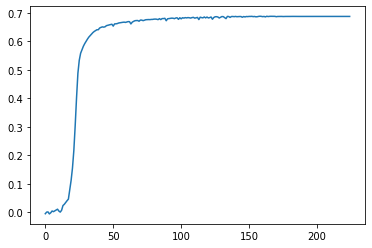

In [69]:
plt.plot(gm_cv.best_estimator_.validation_scores_)
plt.title('Validation scores')
plt.show()

In [71]:
update_scores(gm_cv, 'NN', 'all')

# LightGBM (gradient boosting) 

### 1. LightGBM with standart scaller and one-hot encoding

In [85]:
X_train.columns
isascii = lambda s: len(s) == len(s.encode())
[x for x in list(X_train.columns) if isascii(x)==False]
X_train.c

['dishwasher cycle type_Heavy or “pots and pans” cycle',
 'highest education completed by respondent_Master’s, Professional, or Doctorate degree (for example: MA, MS, MBA, MD, JD, PhD)',
 'highest education completed by respondent_Some college or Associate’s degree']

In [128]:
X_train = X_train.rename(
    columns={
        "dishwasher cycle type_Heavy or “pots and pans” cycle": "dishwasher cycle type_Heavy or pots and pans cycle",
        "highest education completed by respondent_Master’s, Professional, or Doctorate degree (for example: MA, MS, MBA, MD, JD, PhD)": "highest education completed by respondent_Masters, Professional, or Doctorate degree (for example: MA, MS, MBA, MD, JD, PhD)",
        "highest education completed by respondent_Some college or Associate’s degree": "highest education completed by respondent_Some college or Associates degree",
    }
)

X_test = X_test.rename(
    columns={
        "dishwasher cycle type_Heavy or “pots and pans” cycle": "dishwasher cycle type_Heavy or pots and pans cycle",
        "highest education completed by respondent_Master’s, Professional, or Doctorate degree (for example: MA, MS, MBA, MD, JD, PhD)": "highest education completed by respondent_Masters, Professional, or Doctorate degree (for example: MA, MS, MBA, MD, JD, PhD)",
        "highest education completed by respondent_Some college or Associate’s degree": "highest education completed by respondent_Some college or Associates degree",
    }
)

C:\Users\Aleks\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [129]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

parameters = {
    "boosting_type": ["gbdt"],
    "metric": ["rmse"],
    "num_leaves": [20],
    "bagging_fraction": [0.2],
    "feature_fraction": [0.2],
    "learning_rate": [0.001],
    "lambda_l2": [2],
}


model = LGBMRegressor(n_estimators = 40000)
gm_cv = GridSearchCV(model, parameters, cv=5, n_jobs=8)

gm_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=40000, n_jobs=-1,
                                     num_leaves=31, objective=None,
                                     random_state=None, reg_alpha=0.0,
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=8,
             param_grid={'bagging_fraction': [0.2], 'boosting_type': ['gbdt'],
                         'feature_fraction': [0.2], 'la

In [130]:
y_pred = gm_cv.predict(X_test)
r2_score(y_test, y_pred)

0.7091156543907235

In [131]:
lgb = gm_cv.best_estimator_.booster_

### 2. LightGBM without one-hot encoding

According to  LightGBM documentation, it is common to represent categorical features with one-hot encoding, but this approach is suboptimal for tree learners. Particularly for high-cardinality categorical features, a tree built on one-hot features tends to be unbalanced and needs to grow very deep to achieve good accuracy.
Let's try to let  LightGBM to deal with categorical values on it's own to see it this will lead to better performance.

In [97]:
original = pd.read_csv(url, index_col=0)
original[original.select_dtypes(["object"]).columns] = original.select_dtypes(["object"]).apply(
    lambda x: x.astype("category")
)

X_original = original.drop(columns='total_usage')
y_original = original['total_usage']

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.1
)

In [98]:
parameters = {
    "boosting_type": ["gbdt"],
    "metric": ["rmse"],
    "num_leaves": [20, 50],
    "bagging_fraction": [0.2, 0.4],
    "feature_fraction": [0.2],
    "learning_rate": [0.001],
    "lambda_l2": [2, 5],
}


model = LGBMRegressor(n_estimators = 40000)
gm_cv = GridSearchCV(model, parameters, cv=5, n_jobs=8)

gm_cv.fit(X_train_original, y_train_original)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=40000, n_jobs=-1,
                                     num_leaves=31, objective=None,
                                     random_state=None, reg_alpha=0.0,
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=8,
             param_grid={'bagging_fraction': [0.2, 0.4],
                         'boosting_type': ['gbdt'], 'feature_fraction': [0.2]

In [100]:
y_pred = gm_cv.predict(X_test_original)
r2_score(y_test_original, y_pred)

0.7414497532716571

In [118]:
update_scores(gm_cv, 'LightGBM', 'all', X_test = X_test_original, y_test = y_test_original)

In [101]:
gm_cv.best_params_

{'bagging_fraction': 0.2,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.2,
 'lambda_l2': 2,
 'learning_rate': 0.001,
 'metric': 'rmse',
 'num_leaves': 20}

## Using subset of variables

### Choosing subset based on tree feature importance

In [132]:
top_features = pd.DataFrame(
    {"feature_name": lgb.feature_name(), "importance": lgb.feature_importance()}
)

In [133]:
top_features.sort_values(by = 'importance', ascending = False, inplace = True)

In [134]:
top_features.iloc[:10]

,feature_name,importance
66,annual_average_ground_water_temperature_(f)_fo...,19009
59,total_square_footage,18874
58,total_heated_square_footage,17577
68,dry_bulb_design_temperature_(f)_expected_to_be...,16251
65,annual_value_for_latent_heat_infiltration_from...,16240
63,"heating_degree_days,_30-year_average_1981-2010...",15478
57,total_cooled_square_footage,13894
60,total_uncooled_square_footage,13825
62,"cooling_degree_days,_30-year_average_1981-2010...",13357
50,respondent_age,13079


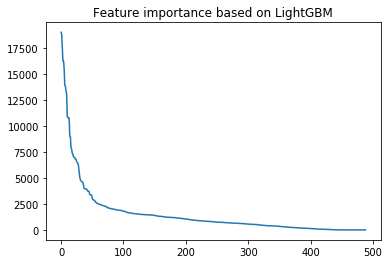

In [192]:
plt.plot(np.arange(len(top_features)), top_features["importance"])
plt.title('Feature importance based on LightGBM')
plt.show()

### SVR
#### Tree-based

In [136]:
for i in [144, 200, 300, 400]:
    parameters = {"kernel": ["rbf"], "C": [5]}
    model = SVR(gamma="auto")
    gm_cv = GridSearchCV(model, parameters, cv=5, n_jobs=8)
    
    X_train_top = X_train.iloc[:,top_features.iloc[:i].index]
    X_test_top = X_test.iloc[:,top_features.iloc[:i].index]


    gm_cv.fit(X_train_top, y_train)

    print("n_featires: {0}, best_cv_score: {1}".format(i, gm_cv.best_score_))
    
    update_scores(gm_cv, "SVM_tree", str(i), X_test = X_test_top, y_test = y_test)

n_featires: 144, best_cv_score: 0.6762390571363424
n_featires: 200, best_cv_score: 0.6950612120468606
n_featires: 300, best_cv_score: 0.7116683073148374
n_featires: 400, best_cv_score: 0.7143136399423284


#### SelectKBest

In [138]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

for i in [144, 200, 300, 400]:
    parameters = {"kernel": ["rbf"], "C": [5]}
    model = SVR(gamma="auto")
    gm_cv = GridSearchCV(model, parameters, cv=5, n_jobs=8)
    
    kbest = SelectKBest(mutual_info_regression, k=i)
    X_train_top = kbest.fit_transform(X_train, y_train)
    X_test_top = kbest.transform(X_test)

    gm_cv.fit(X_train_top, y_train)

    print("n_featires: {0}, best_cv_score: {1}".format(i, gm_cv.best_score_))
    
    update_scores(gm_cv, "SVM_kbest", str(i), X_test = X_test_top, y_test = y_test)

n_featires: 144, best_cv_score: 0.6545535504833786
n_featires: 200, best_cv_score: 0.6840562223070106
n_featires: 300, best_cv_score: 0.7017831573163106
n_featires: 400, best_cv_score: 0.7115723438647323


## NN
#### Tree-based

In [140]:
for i in [144, 200, 300, 400]:
    parameters = {
        "hidden_layer_sizes": [(128, 128, 16)],
        "activation": ["logistic"],
        "solver": ["sgd"],
        "alpha": [0.0001],
        "max_iter": [5000],
        "learning_rate_init": [0.01],
        "learning_rate": ["adaptive"],
    }
    model = MLPRegressor(early_stopping=True, validation_fraction=0.2)
    gm_cv = GridSearchCV(model, parameters, cv=5, n_jobs=8)

    X_train_top = X_train.iloc[:, top_features.iloc[:i].index]
    X_test_top = X_test.iloc[:, top_features.iloc[:i].index]

    gm_cv.fit(X_train_top, y_train)

    print("n_featires: {0}, best_cv_score: {1}".format(i, gm_cv.best_score_))

    update_scores(gm_cv, "NN_tree", str(i), X_test=X_test_top, y_test=y_test)

n_featires: 144, best_cv_score: 0.6942357516675722
n_featires: 200, best_cv_score: 0.6988563171028668
n_featires: 300, best_cv_score: 0.7167163835424433
n_featires: 400, best_cv_score: 0.7022261946043948


#### SelectKBest

In [141]:
for i in [144, 200, 300, 400]:
    parameters = {
        "hidden_layer_sizes": [(128, 128, 16)],
        "activation": ["logistic"],
        "solver": ["sgd"],
        "alpha": [0.0001],
        "max_iter": [5000],
        "learning_rate_init": [0.01],
        "learning_rate": ["adaptive"],
    }
    model = MLPRegressor(early_stopping=True, validation_fraction=0.2)
    gm_cv = GridSearchCV(model, parameters, cv=5, n_jobs=8)

    kbest = SelectKBest(mutual_info_regression, k=i)
    X_train_top = kbest.fit_transform(X_train, y_train)
    X_test_top = kbest.transform(X_test)

    gm_cv.fit(X_train_top, y_train)

    print("n_featires: {0}, best_cv_score: {1}".format(i, gm_cv.best_score_))

    update_scores(gm_cv, "NN_kbest", str(i), X_test=X_test_top, y_test=y_test)

n_featires: 144, best_cv_score: 0.671937157095593
n_featires: 200, best_cv_score: 0.6922020422059797
n_featires: 300, best_cv_score: 0.7074103074072244
n_featires: 400, best_cv_score: 0.7093644459351717


Tree based feature importance gives better result. 

# Results
The best overall model (all 254 variables ):  **LightGBM** without one-hot encoding (**$R^2$ 0.76 validation score**)

The best model on subset of variables (138 out of 489 one-hot encoded variables):  **ElasticNet** (**$R^2$ 0.72 validation score**)

In [185]:
r2_scores_st = pd.DataFrame(r2_scores.stack())
r2_scores_st.reset_index(level=[0, 1], inplace=True)
r2_scores_st = r2_scores_st.rename(columns={"level_0": "method", "level_1": "features", 0: "value"})

In [189]:
MSE_scores.at['LightGBM', 'all'] = np.nan
MSE_scores_st = pd.DataFrame(MSE_scores.stack())
MSE_scores_st.reset_index(level=[0, 1], inplace=True)
MSE_scores_st = MSE_scores_st.rename(columns={"level_0": "method", "level_1": "features", 0: "value"})

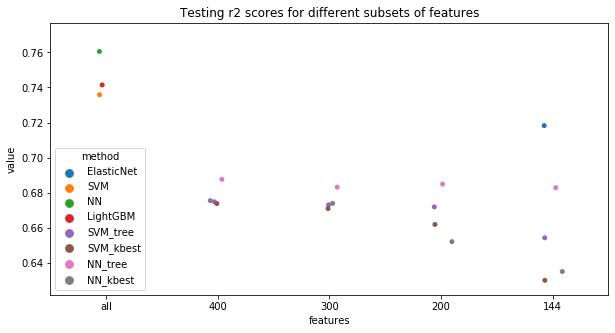

In [193]:
plt.figure(figsize=(10, 5))

sns.stripplot(
    x="features",
    y="value",
    hue="method",
    data=r2_scores_st,
    order=["all", "400", "300", "200", "144"],
)
plt.title('Testing r2 scores for different subsets of features')
plt.show()

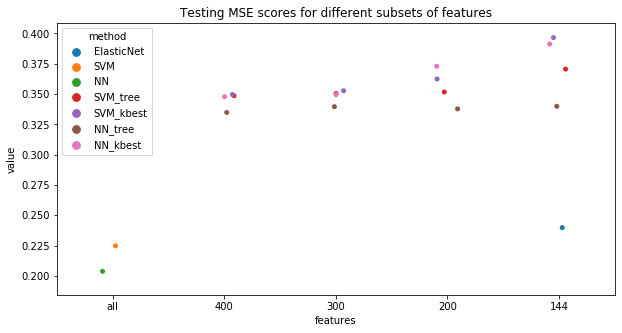

In [194]:
plt.figure(figsize=(10, 5))

sns.stripplot(
    x="features",
    y="value",
    hue="method",
    data=MSE_scores_st,
    order=["all", "400", "300", "200", "144"],
)

plt.title('Testing MSE scores for different subsets of features')
plt.show()